<a href="https://colab.research.google.com/github/csendranshi/MLworkshopSFIT/blob/master/Sequence_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Loading

In [2]:
plt.style.use("ggplot")
data = pd.read_csv("ner_dataset - ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.tail(12)
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
tags = sorted(list(set(data["Tag"].values)))
n_tags = len(tags)
print(n_words,n_tags)

35168 17


# Data Preprocessing

In [3]:
class SentenceGetter(object):
  def __init__(self, data):
      self.n_sent = 1
      self.data = data
      self.empty = False
      agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
      self.grouped = self.data.groupby("Sentence #").apply(agg_func)
      self.sentences = [s for s in self.grouped]

  def get_next(self):
      try:
          s = self.grouped["Sentence: {}".format(self.n_sent)]
          self.n_sent += 1
          return s
      except:
          return None

In [4]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [5]:
print(getter.get_next())

[('Families', 'O'), ('of', 'O'), ('soldiers', 'O'), ('killed', 'O'), ('in', 'O'), ('the', 'O'), ('conflict', 'O'), ('joined', 'O'), ('the', 'O'), ('protesters', 'O'), ('who', 'O'), ('carried', 'O'), ('banners', 'O'), ('with', 'O'), ('such', 'O'), ('slogans', 'O'), ('as', 'O'), ('"', 'O'), ('Bush', 'B-per'), ('Number', 'O'), ('One', 'O'), ('Terrorist', 'O'), ('"', 'O'), ('and', 'O'), ('"', 'O'), ('Stop', 'O'), ('the', 'O'), ('Bombings', 'O'), ('.', 'O'), ('"', 'O')]


In [6]:

sentences = getter.sentences
print(len(sentences))

47959


In [7]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


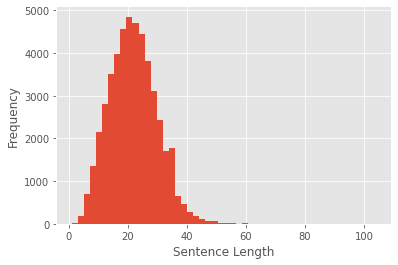

In [8]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences],bins=50)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [9]:

max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[0]
sentences[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [10]:
from keras.preprocessing.sequence import pad_sequences
tags2index = {t:i for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y

Using TensorFlow backend.


array([[16, 16, 16, ..., 16, 16, 16],
       [ 3, 16, 16, ..., 16, 16, 16],
       [16, 16,  7, ..., 16, 16, 16],
       ...,
       [16,  2, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       [16,  5, 13, ..., 16, 16, 16]], dtype=int32)

# Model Building and Training

In [11]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub #created by google,hosts pretrained networks
from keras import backend as K
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)
elmo_model = hub.KerasLayer("https://tfhub.dev/google/elmo/3",trainable=False,
                            signature='tokens', output_key='elmo')
sess.run(tf.compat.v1.global_variables_initializer())
sess.run(tf.compat.v1.tables_initializer())

In [12]:
batch_size = 32
def ElmoEmbedding(x):
    
    return elmo_model(inputs={'tokens':tf.squeeze(tf.cast(x,tf.string)),
                              'sequence_len':tf.constant(batch_size*[max_len])})

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add,Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len,1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input_text, out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (32, None, 1024)     0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (32, None, 1024)     6295552     lambda[0][0]                     
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (32, None, 1024)     6295552     bidirectional[0][0]              
______________________________________________________________________________________________

In [14]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
history = model.fit(np.array(X_tr), np.array(y_tr), validation_data=(np.array(X_val), np.array(y_val)),batch_size=batch_size, epochs=1, verbose=1)

Train on 38816 samples, validate on 4320 samples
38816/38816 [==============================] - 869s 22ms/sample - loss: 0.0619 - accuracy: 0.9819 - val_loss: 0.0463 - val_accuracy: 0.9855


In [15]:
model.save_weights('bilstm_model.hdf5')

In [16]:
!pip install seqeval

# Model Evaluation

In [17]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

In [18]:
idx2tag = {i: w for w, i in tags2index.items()}
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      geo       0.81      0.91      0.86      3720
      org       0.62      0.64      0.63      2061
      tim       0.83      0.84      0.84      2148
      gpe       0.95      0.92      0.93      1591
      per       0.70      0.75      0.72      1677
      art       0.50      0.02      0.04        49
      nat       0.30      0.41      0.35        22
      eve       0.37      0.21      0.27        33

micro avg       0.78      0.82      0.80     11301
macro avg       0.78      0.82      0.80     11301



In [19]:
i = 390
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "__PAD__":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

Word            Pred : (True)
Citing         :O     (O)
a              :O     (O)
draft          :O     (O)
report         :O     (O)
from           :O     (O)
the            :O     (O)
U.S.           :B-org (B-org)
Government     :I-org (I-org)
Accountability :I-org (O)
office         :O     (O)
,              :O     (O)
The            :B-org (B-org)
New            :I-org (I-org)
York           :I-org (I-org)
Times          :I-org (I-org)
said           :O     (O)
Saturday       :B-tim (B-tim)
the            :O     (O)
losses         :O     (O)
amount         :O     (O)
to             :O     (O)
between        :O     (O)
1,00,000       :O     (O)
and            :O     (O)
3,00,000       :O     (O)
barrels        :O     (O)
a              :O     (O)
day            :O     (O)
of             :O     (O)
Iraq           :B-geo (B-geo)
s              :O     (O)
declared       :O     (O)
oil            :O     (O)
production     :O     (O)
over           :O     (O)
the            :O     (O)
pa

In [20]:
history.history

{'accuracy': [0.98194814],
 'loss': [0.061948852788623165],
 'val_accuracy': [0.9854676],
 'val_loss': [0.046291523909679166]}

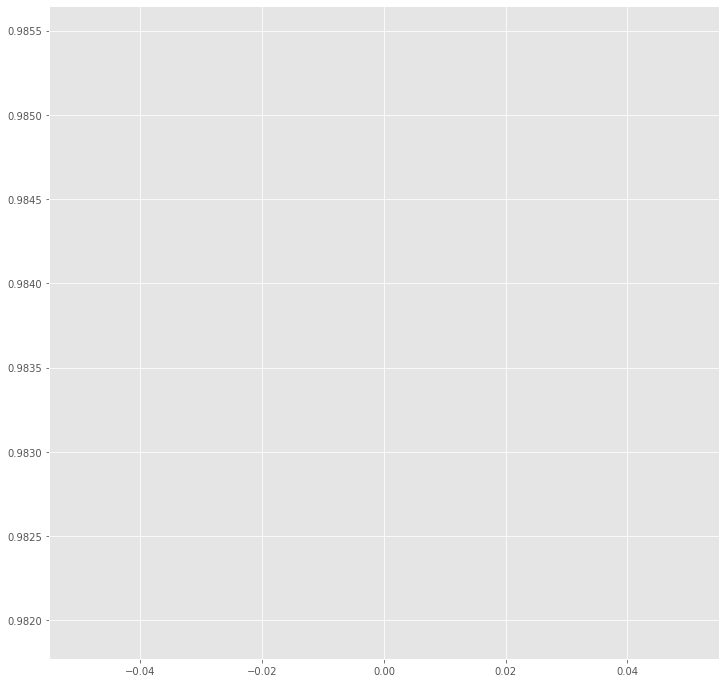

In [21]:
plt.figure(figsize=(12,12))
plt.plot(history.history["accuracy"],c = 'b')
plt.plot(history.history["val_accuracy"], c = 'g')
plt.show()

In [22]:
test_sentence = [["Hawking", "is", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]]

In [23]:
max_len = 50
X_test = [[w for w in s] for s in test_sentence]
new_X_test = []
for seq in X_test:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X_test.append(new_seq)
new_X_test

[['Hawking',
  'is',
  'a',
  'Fellow',
  'of',
  'the',
  'Royal',
  'Society',
  ',',
  'a',
  'lifetime',
  'member',
  'of',
  'the',
  'Pontifical',
  'Academy',
  'of',
  'Sciences',
  ',',
  'and',
  'a',
  'recipient',
  'of',
  'the',
  'Presidential',
  'Medal',
  'of',
  'Freedom',
  ',',
  'the',
  'highest',
  'civilian',
  'award',
  'in',
  'the',
  'United',
  'States',
  '.',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword',
  'PADword']]

In [24]:
np.array(new_X_test,dtype='<U26')

array([['Hawking', 'is', 'a', 'Fellow', 'of', 'the', 'Royal', 'Society',
        ',', 'a', 'lifetime', 'member', 'of', 'the', 'Pontifical',
        'Academy', 'of', 'Sciences', ',', 'and', 'a', 'recipient', 'of',
        'the', 'Presidential', 'Medal', 'of', 'Freedom', ',', 'the',
        'highest', 'civilian', 'award', 'in', 'the', 'United', 'States',
        '.', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword',
        'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword',
        'PADword']], dtype='<U26')

In [25]:
np.array(X_te)[1]

array(['Iran', 'says', 'its', 'nuclear', 'program', 'is', 'for',
       'peaceful', 'purposes', 'only', '.', 'PADword', 'PADword',
       'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword',
       'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword',
       'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword',
       'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword',
       'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword',
       'PADword', 'PADword', 'PADword', 'PADword', 'PADword', 'PADword',
       'PADword'], dtype='<U26')

# Inference

In [26]:
model.load_weights('bilstm_model.hdf5') #WHEN LOADING FROM MODEL FILE UNCOMMENT THIS LINE AND THE NEXT LINE
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
p = model.predict(np.array(new_X_test*32,dtype='<U26'))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, pred in zip(new_X_test[0], p):
    if w != "__PAD__":
        print("{:15}:{:5}".format(w, tags[pred]))#,tags[true]))

Word            Pred : (True)
Hawking        :B-per
is             :O    
a              :O    
Fellow         :O    
of             :O    
the            :O    
Royal          :B-org
Society        :I-org
,              :O    
a              :O    
lifetime       :O    
member         :O    
of             :O    
the            :O    
Pontifical     :B-org
Academy        :I-org
of             :I-org
Sciences       :I-org
,              :O    
and            :O    
a              :O    
recipient      :O    
of             :O    
the            :O    
Presidential   :B-org
Medal          :I-org
of             :I-org
Freedom        :I-org
,              :O    
the            :O    
highest        :O    
civilian       :O    
award          :O    
in             :O    
the            :O    
United         :B-geo
States         :I-geo
.              :O    
PADword        :O    
PADword        :O    
PADword        :O    
PADword        :O    
PADword        :O    
PADword        :O    
PA